# Direct TSQR
**Input**: Matrix $A$ of size $m\times n$ (with $m\gg n$)
1) **First step**: The matrix $A$ is subdivided into $p$ sub-matricies of size $m_j\times n$ and *map* procedure, perform a local QR decomposition on each sub-matrix, resulting on $\{(Q^{(1)}_1, R_1),(Q^{(1)}_2, R_2),...,(Q^{(1)}_p, R_p)\}$, where $Q_j^{(1)}\in\mathbb{R}^{m_j\times n}$ and $R_j\in\mathbb{R}^{n\times n}$.
2) **Second step**: a *reduce* task collect each $R_j$ into a $np\times n$ matrix. A second QR decomposition returns a $\tilde{Q}=[Q^{(2)}_1,...,Q^{(2)}_p]^T \in \mathbb{R}^{np\times n}$ (each $Q_j^{(2)}$ is $n\times n$) and $\tilde{R}\in\mathbb{R}^{n\times n}$
3) **Third step**: a *map* task build the final $Q$ matrix using $Q_j=Q_j^{(1)}Q_j^{(2)}$


In [26]:
from dask.distributed import Client, wait
from dask import delayed, compute
import dask.array as da

from numpy.linalg import qr
import numpy as np

N_WORKERS = 8
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "2GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("DASK Dashboard link:", client.dashboard_link)

DASK Client with 8 workers (1 threads, 2GB memory)
DASK Dashboard link: http://127.0.0.1:8787/status


In [27]:
def _get_q(qr : tuple[delayed, delayed]) -> delayed:
    return qr[0]

def _get_r(qr : tuple[delayed, delayed]) -> delayed:
    return qr[1]

def direct_tsqr(A : da.Array, client : Client, mode : str = None) -> tuple[delayed, delayed]:
    A_blocks = A.to_delayed().ravel().tolist()
    A_blocks_futures = client.compute(A_blocks)
    wait(A)
    
    # Step 1: (map) perform QR decomposition in parallel on each block
    QR1 = client.map(qr, A_blocks_futures)
    wait(QR1)
    Q1s_future = client.map(_get_q, QR1)
    R1s_future = client.map(_get_r, QR1)
    wait(R1s_future)

    # Step 2: (reduce) perform global QR decomposition
    R1s = client.gather(R1s_future)
    R_stacked = np.vstack(R1s)
    Q2, R_final = qr(R_stacked)

    if mode == "r":
        return None, R_final
    
    p, n = len(R1s), R_final.shape[1]
    Q2_blocks = [Q2[i*n:(i+1)*n, :] for i in range(p)]

    # Step 3: (map) building the final Q by multiplying Qs blocks
    Q2s_futures = client.scatter(Q2_blocks) 
    wait(Q2s_futures)
    wait(Q1s_future)
    Qs_future = client.map(np.matmul, Q1s_future, Q2s_futures)
    wait(Qs_future)
    Q = delayed(np.vstack)(Qs_future)

    return Q, R_final


def direct_tsqr_delayed(A : da.Array, client : Client, mode : str = None) -> tuple[delayed, delayed]:
    A_blocks = A.to_delayed().ravel().tolist()
    
    # Step 1: (map) perform QR decomposition in parallel on each block
    QR1 = [delayed(qr)(block) for block in A_blocks]
    Q1s = [delayed(_get_q)(qr) for qr in QR1]
    R1s = [delayed(_get_r)(qr) for qr in QR1]
    R1 = delayed(np.vstack)(R1s)

    # Step 2: (reduce) perform global QR decomposition
    QR2 = delayed(qr)(R1)
    Q2 = delayed(_get_q)(QR2)
    R2 = delayed(_get_r)(QR2)

    if mode == "r":
        return None, R2

    # Step 3: (map) building the final Q by multiplying Qs blocks
    p, n = len(A_blocks), A.shape[1]
    Q2_blocks = [delayed(lambda Q2, i, n: Q2[i*n:(i+1)*n, :])(Q2, i, n) for i in range(p)]
    Qs = [delayed(np.matmul)(Q1, Q2b) for Q1, Q2b in zip(Q1s, Q2_blocks)]
    Q = delayed(np.vstack)(Qs)
    
    client.cancel([R1, QR1])
    return Q, R2

In [28]:
m, n = int(1e7), 4
A = da.random.random((m, n), chunks=(m // N_WORKERS, n))
A

dask.array<random_sample, shape=(10000000, 4), dtype=float64, chunksize=(1250000, 4), chunktype=numpy.ndarray>

In [29]:
%%time

# Parallel computation with delayed
Q_delayed, R_delayed = direct_tsqr_delayed(A, client)
Q, R = compute(Q_delayed, R_delayed)

CPU times: user 89.9 ms, sys: 141 ms, total: 231 ms
Wall time: 703 ms


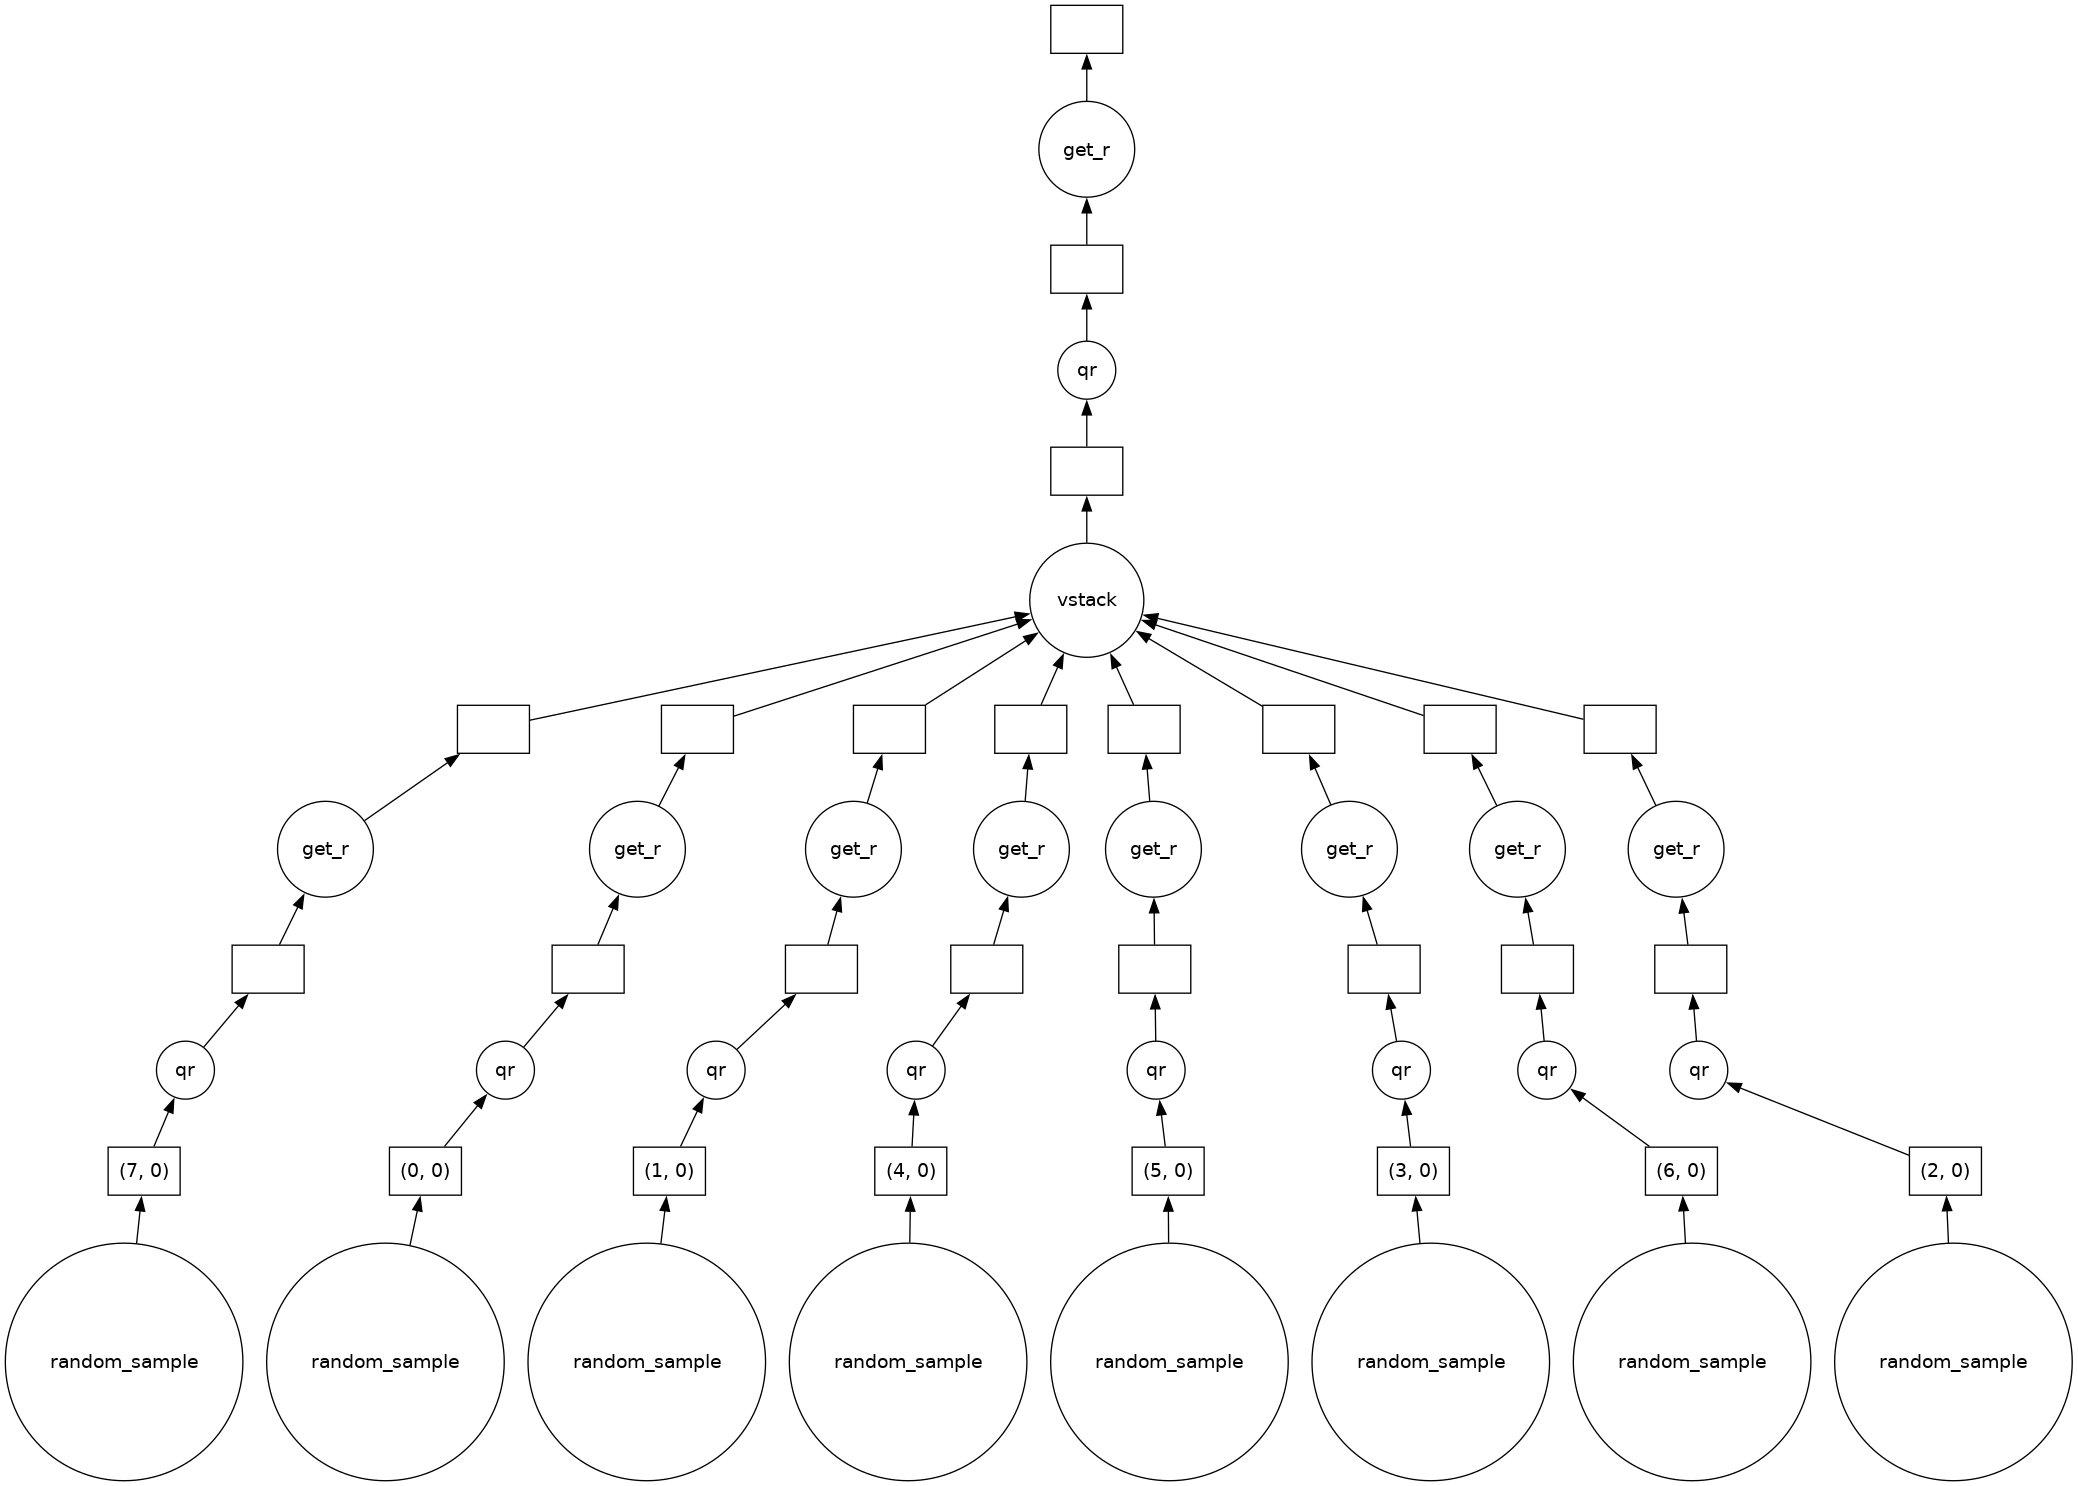

In [35]:
Q_delayed.visualize("./fig/Direct_Q.png", optimize_graph=True)
R_delayed.visualize("./fig/Direct_R.png", optimize_graph=True)

In [16]:
%%time

# Parallel computation with intermediate results
Q_delayed, R_delayed = direct_tsqr(A, client)
Q, R = compute(Q_delayed, R_delayed)

CPU times: user 47.5 ms, sys: 278 ms, total: 326 ms
Wall time: 671 ms


In [17]:
%%time

# Parallel computation with dask implementation
Q_future, R_future = da.linalg.qr(A)
Q, R = da.compute(Q_future, R_future)

CPU times: user 56 ms, sys: 158 ms, total: 214 ms
Wall time: 584 ms


In [ ]:
# Gathering A for subsequent calculations
A_local = A.compute()

In [20]:
%%time

# Sequential computation 
Q_seq, R_seq = qr(A_local)

CPU times: user 356 ms, sys: 523 ms, total: 879 ms
Wall time: 848 ms


In [21]:
# Check the results
print("Reconstruction error check:", np.isclose(Q @ R, A_local, atol=1e-6).all())
print("Orthogonality check:", np.linalg.norm(Q.T @ Q - np.eye(n), ord='fro') < 1e-6)

Reconstruction error check: True
Orthogonality check: True


In [23]:
client.close()